# Deterministic slice flows

Vectorized version of the functions in `density_evaluation`.

Consider a target density $\pi(x_{1:M},u_{1:M})=p(x_{1:M})1_{[0,1]}(u_{1:M})$ 
where we have access to the full conditionals $p_m$ 
and let $F_m,Q_m$ be the cdf and quantile functions of $p_m$.
We approximate $\pi$ with a variational ergodic flow
$$
    q_N=\frac{1}{N}\sum_{n=0}^N T^nq_0,
$$
where $q_0$ is a reference distribution and
$T=T_m\circ\cdots\circ T_1$ mimics Gibbs sampling, i.e.,
each map $T_m$ updates only $(x_m,u_m)\mapsto(x_m',u_m')$.
Specifically,
$$
\begin{pmatrix}x_m'\\u_m'\end{pmatrix}=
\begin{pmatrix}
    Q_m(\rho(x_m,u_m)+\xi\mod 1)\\ 
    \frac{1}{p_m(x_m')}((\rho(x_m,u_m)+\xi\mod 1)-F(x_m'))
\end{pmatrix},
$$
where $\rho(x,u)=F_m(x-1)+up_m(x)$ converts to proportions and $F_m(0)=0$ by convention.

In the notes,
I showed that the variational density can be evaluated in closed form
since the Jacobians of the continuous restriction correspond to density ratios. Specifically,
$$
    q_N(x_{1:M},u_{1:M})
    =\frac{1}{N}\sum_{n=0}^{N-1}
    q_0(T^{-n}(x_{1:M},u_{1:M})
    \prod_{j=1}^n\prod_{m=1}^M \frac{p_m(T^{-j+1}(x_{1:M},u_{1:M}))}{p_m(T^{-j}(x_{1:M},u_{1:M}))}.
$$

First we define all the necessary functions.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
########################################
########################################
# variational approximation functions
########################################
########################################
def lqN(x,u,N,lq0,lp,xi=np.pi/16):
    # evaluate variational log likelihood log qN(x,u)
    #
    # inputs:
    #    x         : (M,d) array, states of xm
    #    u         : (M,d) array, values of um
    #    N         : int, variational parameter; max number of applications of T
    #    lq0       : function, reference log likelihood (vectorized)
    #    lp        : function, target log likelihood (vectorized)
    #    xi        : scalar, uniform shift
    #
    # outputs:
    #   logqN(x,u) : (d,) array, likelihood at each datum x_i
    
    if N==1: return lq0(x,u)
    w=np.zeros((N,x.shape[1]))
    w[0,:]=lq0(x,u)
    LJ=np.zeros(x.shape[1])
    for n in range(N-1):
        sprbs=np.sum(lp(x),axis=0)
        x,u=flow(x,u,1,lp,xi,direction='bwd')
        LJ=LJ+sprbs-np.sum(lp(x),axis=0)
        w[n+1,:]=lq0(x,u)+LJ
    # end for
    return LogSumExp(w)-np.log(N)

def randqN(size,N,lp,randq0,xi=np.pi/16):
    # generate samples from the variational distribution qN
    #
    # inputs:
    #    size   : int, number of samples to generate
    #    N      : int, variational parameter; max number of applications of T
    #    lp        : function, target log likelihood (vectorized)
    #    randq0 : function, reference distribution sampler
    #    xi        : scalar, uniform shift
    #
    # outputs:
    #   sx      : (M,size) array, x samples from qN
    #   su      : (M,size,) array, u samples from qN
    
    if N==1: return randq0(size)
    K=np.random.randint(low=0,high=N,size=size)
    x,u=randq0(size)
    for n in range(N-1):
        tx,tu = flow(x[:,K>=n+1],u[:,K>=n+1],steps=1,lp=lp,xi=xi,direction='fwd') # update those with large enough K
        x[:,K>=n+1]=tx 
        u[:,K>=n+1]=tu
    return x,u
    


########################################
########################################
# flow functions
########################################
########################################
def flow(x,u,steps,lp,xi=np.pi/16,direction='fwd'):
    # compute T^n(x,u)
    #
    # inputs:
    #    x         : (M,d) array, initial states of x
    #    u         : (M,d) array, initial values of u
    #    steps     : int, number of applications of T, n
    #    lp        : function, posterior and conditional pmf
    #    xi        : scalar, uniform shift
    #    direction : string, one of 'fwd' (forward map) or 'bwd' (backward map)
    #
    # outputs:
    #   x' : (M,d) array, updated states x'
    #   u' : (M,d) array, updated values u'
    
    M=x.shape[0]
    if steps==0: return x,u
    for t in range(steps):
        for m in range(M):
            m_idx = m if direction=='fwd'else M-m-1 # if in reverse, update starting from the end
            tmp_prbs=np.atleast_1d(np.exp(lp(x,axis=m_idx)))
            tmp_prbs=tmp_prbs/np.sum(tmp_prbs,axis=1)[:,np.newaxis]
            tx,tu=Tm(x[m_idx,:],u[m_idx,:],tmp_prbs,xi,direction=direction)
            x[m_idx,:]=tx
            u[m_idx,:]=tu
        # end for
    # end for
    return x,u
        
    
def Tm(x,u,prbs,xi=np.pi/16,direction='fwd'):
    # compute Tm(x,u)
    #
    # inputs:
    #    x         : (d,) array, states of xm
    #    u         : (d,) array, values of um
    #    prbs      : (d,Km) array, probabilities of Xm|X-m for each of the d xm's
    #    xi        : scalar, uniform shift
    #    direction : string, one of 'fwd' (forward map) or 'bwd' (backward map)
    #
    # outputs:
    #   xp : (d,) array, updated states xm'
    #   up : (d,) array, updated values um'
    
    if direction=='bwd': xi=-xi
    p=getp(x,u,prbs,xi)
    xp=quantile(p,prbs)
    up=(p-cdf(xp-1,prbs))/prbs[np.arange(0,xp.shape[0]),xp]
    return xp,up


def getp(x,u,prbs,xi=np.pi/16):
    # get proportion from current pair (xm,um)
    # equivalent to rho+xi mod 1 in paper
    #
    # inputs:
    #    x         : (d,) array, states of xm
    #    u         : (d,) array, values of um
    #    prbs      : (d,Km) array, probabilities of Xm|X-m for each of the d xm's
    #    xi        : scalar, uniform shift
    #
    # outputs:
    #   p' : (d,) array, proportion and shifted states p'
    
    p=u*prbs[np.arange(0,x.shape[0]),x]
    F=np.cumsum(prbs,axis=1) # cdf
    p[x>0]=p[x>0]+np.squeeze(F[np.where(x>0),x[x>0]-1]) # vectorized "+prbs[:x] if x>0"
    return (p+xi)%1
    
    
########################################
########################################
# inference
########################################
########################################
def elbo(B,lp,N,M,lq0,randqN,randq0,xi=np.pi/16):
    tx,tu=randqN(B,N,randq0)
    elbos=np.zeros(B)
    for b in range(B): elbos[b]=lp(np.atleast_1d(tx[b]))-lqN(np.atleast_1d(tx[b]),np.atleast_1d(tu[b]),N,lq0,lp,xi)
    return np.mean(elbos)
        

########################################
########################################
# auxiliary functions
########################################
########################################
def LogSumExp(w):
    # LogSumExp trick
    #
    # inputs:
    #    w : (N,d) array, exponents
    #
    # outputs:
    #    w' : (N,d) array, log(sum(exp(w)))
    wmax = np.amax(w,axis=0)
    return wmax + np.log(np.sum(np.exp(w-wmax[np.newaxis,:]),axis=0))

def cdf(x,prbs): 
    # cdf of x given prbs (vectorized): F(x)
    #
    # inputs:
    #    x    : (d,) array, states of xm
    #    prbs : (d,Km) array, probabilities of Xm|X-m for each of the d xm's
    #
    # outputs:
    #   F(x) : (d,) array, cdf of X at each xi (F(x)_i=F(x_i))
    
    F=np.hstack((np.zeros((prbs.shape[0],1)),np.cumsum(prbs,axis=1))) # adding 0's so F(0)=0
    return F[np.arange(0,x.shape[0]),x+1]

def quantile(u,prbs): 
    # quantile function of u given prbs (badly vectorized)
    # via scipy stats, couldn't implement in native numpy
    #
    # inputs:
    #    u    : (d,) array, values of um
    #    prbs : (d,Km) array, probabilities of Xm|X-m for each of the d xm's
    #
    # outputs:
    #   Q(x) : (d,) array, quantile of X at each ui (Q(u)_i=Q(u_i))
    quants=np.zeros(u.shape[0])
    for d in range(u.shape[0]):
        tmprv=stats.rv_discrete(values=(np.arange(0,prbs.shape[1]), prbs[d,:]))
        quants[d]=tmprv.ppf(u[d])
    return quants.astype(int)


def gen_lp(prbs):
    # generate an iterable lp function given probs array prbs
    #
    # inputs:
    #    prbs : (K1,...,KM) array, probabilities
    #
    # outputs:
    #   my_lp : function, obtains joint and conditional probabilities
    #           my_lp(x)      -> joint at states x
    #           my_lp(x,axis) -> conditional of x_axis given x_{-axis}
    
    def my_lp(x,axis=None):
        if axis==None: return prbs[tuple(x)] # evaluate lp(x)
        # else return prbs[x_1,x_2,...,x_{m-1},:,x_{m+1},...,x_M] with m=axis
        tmp_prbs=np.ones(prbs.shape[axis]) # init uniform
        tmp_x=np.copy(x)
        for i in range(prbs.shape[axis]):
            tmp_x[axis]=i
            tmp_prbs[i]=prbs[tuple(tmp_x)] 
        # end for
        return tmp_prbs
    return my_lp

## Sanity checks

In [3]:
# generate the distribution
np.random.seed(2022)
K1=4
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return ext_lprb[np.arange(0,x.shape[1]),x]
    return ext_lprb

In [4]:
x=np.array([0,3],dtype=int).reshape(1,2)
u=np.array([0.5,0.99]).reshape(1,2)
print(x,u)
x,u=flow(x,u,10,lp,direction='fwd')
print(x,u)
x,u=flow(x,u,10,lp,direction='bwd')
print(x,u)

[[0 3]] [[0.5  0.99]]
[[3 3]] [[0.602923  0.4992882]]
[[0 3]] [[0.5  0.99]]


In [5]:
lq0 = lambda x,u : np.log(1/K1)*np.ones(x.shape[1])
def randq0(size): return np.random.randint(0,K1,size).reshape(1,size),np.random.rand(1,size)

In [6]:
np.random.seed(2022)
size=1000
N=50

xsamples,_=randqN(size,N,lp,randq0)

Text(0.5, 1.0, 'histogram of samples from $q_N$ for large $N$ against target $p$')

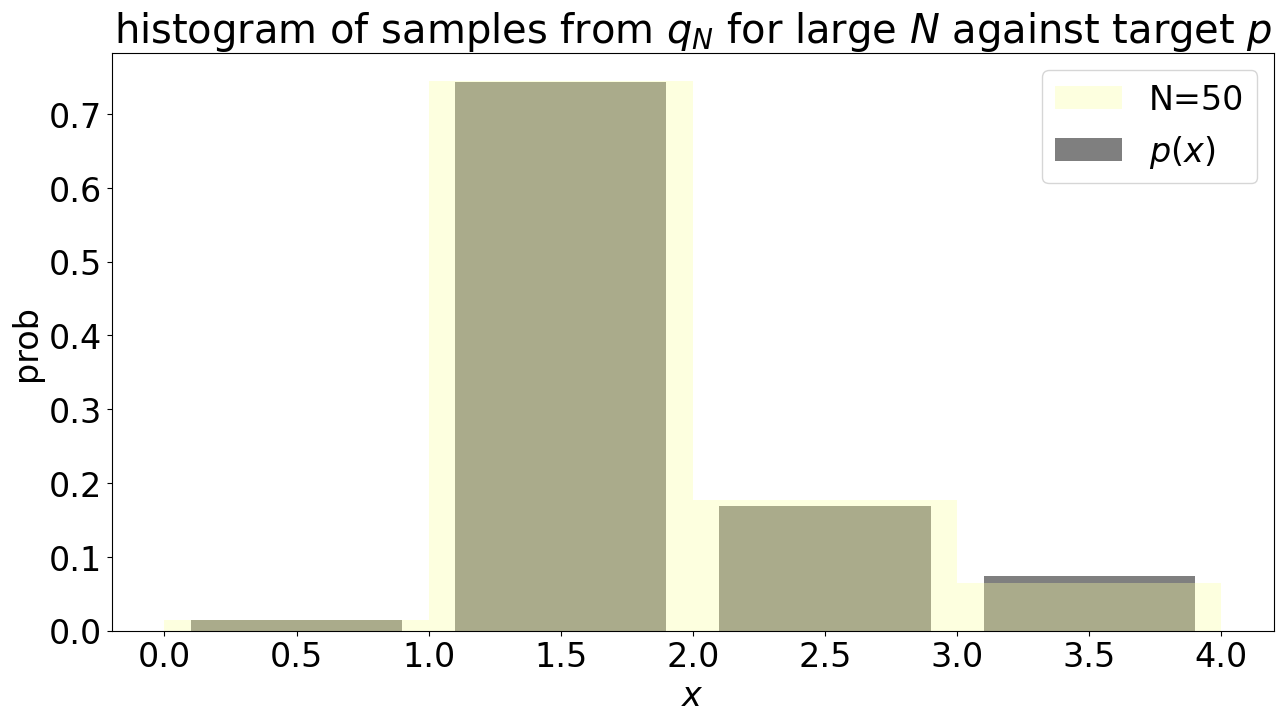

In [7]:
ttx=np.arange(0,prbs.shape[0])
plt.bar(ttx+0.5,prbs, alpha=0.5, label=r'$p(x)$',color="black")
plt.hist(xsamples[0,:],density=True,bins=[0,1,2,3,4],alpha=0.35, label='N='+str(N), color="#FCFFA4FF")
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel('prob')
plt.title(r'histogram of samples from $q_N$ for large $N$ against target $p$')